In [1]:
# Some enhancements :
# - Increase number of 

from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 

import pickle
import lasagne
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
from lasagne.layers import DenseLayer, DropoutLayer, NonlinearityLayer, InputLayer
from lasagne.layers import Pool2DLayer as PoolLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax, leaky_rectify, rectify
from lasagne.layers import get_output, get_all_params
import theano

from samplelayer import SimpleSampleLayer
# import distributions

#theano.config.optimizer = 'None'
#theano.config.exception_verbosity='high'
# theano.config.compute_test_value = 'warn' 
theano.config.optimizer='fast_compile'
#theano.config.lib.cnmem = 0.95

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [2]:
TRAIN_FILE = 'x_train_1000Samples.p'
VALIDATION_FILE = 'x_train_1000SamplesValidation.p'
TARGET_FILE = 'targets_train_1000Samples.p'
TARGET_VALIDATION_FILE = 'targets_train_1000SamplesValidation.p'

# TRAIN_FILE = 'x_train.p'
# VALIDATION_FILE = 'x_train_validation.p'
# TARGET_FILE = 'targets_train.p'
# TARGET_VALIDATION_FILE = 'targets_train_validation.p'

In [3]:
def convertToGrayScale(img):
    R = img[0, :, :]
    G = img[1, :, :]
    B = img[2, :, :]
    img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
    return img_gray

def resize_image(image,x):
    return cv2.resize(image, (x, x))

In [4]:
import cv2
reshape = 128
def load_data():
    with open(TRAIN_FILE, 'r') as f:
        x_train = pickle.load(f)
    with open(VALIDATION_FILE, 'r') as f:
        x_valid = pickle.load(f)
    targets_train = []
    targets_valid = []
    x_train = np.asarray(x_train).squeeze(axis=1)
    x_valid = np.asarray(x_valid).squeeze(axis=1)
    
    for i in x_train:
        targets_train.append(resize_image(convertToGrayScale(i), reshape).flatten())
    for i in x_valid:
        targets_valid.append(resize_image(convertToGrayScale(i), reshape).flatten())
        
    targets_train = np.asarray(targets_train, dtype=np.float32)
    targets_valid = np.asarray(targets_valid, dtype=np.float32)
    
    return x_train, x_valid, targets_train, targets_valid

In [5]:
x_train, x_valid, targets_train, targets_valid = load_data()

print x_train.shape
print x_valid.shape
print targets_train.shape
print targets_valid.shape

def convertTargets(targets):
    temp_targets = []
    for target in targets:
        target = np.asarray(target)
        temp_targets.append(np.where(target==1)[0][0])
    return temp_targets

with open(TARGET_FILE, 'r') as f:
    class_targets_train = pickle.load(f)

with open(TARGET_VALIDATION_FILE, 'r') as f:
    class_targets_valid = pickle.load(f)
class_targets_train = np.asarray(convertTargets(class_targets_train))
class_targets_valid = np.asarray(convertTargets(class_targets_valid))

(3930, 3, 224, 224)
(1973, 3, 224, 224)
(3930, 16384)
(1973, 16384)


In [6]:
NUM_LATENT_Z = 256 #2
NUM_CLASSES = 4

def create_network():
    net = {}

    # VGG Net
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8_not_used'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob_not_used'] = NonlinearityLayer(net['fc8_not_used'], softmax)
    
    set_vgg_params(net)

    # VAE
#     net['fc9'] = DenseLayer(net['fc6_dropout'], num_units=4096, nonlinearity=rectify)
#     net['fc9_dropout'] = DropoutLayer(net['fc9'], p=0.5)
    net['enc_vae'] = DenseLayer(net['fc7_dropout'], num_units=1024, nonlinearity=leaky_rectify)
    net['muq_vae'] = DenseLayer(net['enc_vae'], num_units=NUM_LATENT_Z, nonlinearity=None)     #mu(x)
    net['logvarq_vae'] = DenseLayer(net['enc_vae'], num_units=NUM_LATENT_Z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x)
    net['z_vae'] = SimpleSampleLayer(mean=net['muq_vae'], log_var=net['logvarq_vae']) # sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#     net['z_vae'] = net['muq_vae']
    net['in_z_vae'] = InputLayer(shape=(None, NUM_LATENT_Z))
    #net['dec_vae'] = DenseLayer(net['in_z_vae'], num_units=128, nonlinearity=leaky_rectify)

    # Vanilla network
    net['dec1'] = DenseLayer(net['in_z_vae'], num_units=1024, nonlinearity=rectify)
    net['dec1_dropout'] = DropoutLayer(net['dec1'], p=0.5)
    net['dec2'] = DenseLayer(net['dec1_dropout'], num_units=4096, nonlinearity=rectify)
    net['dec2_dropout'] = DropoutLayer(net['dec2'], p=0.5)
    net['dec3'] = DenseLayer(net['dec2_dropout'], num_units=8192, nonlinearity=rectify)
    net['dec3_dropout'] = DropoutLayer(net['dec3'], p=0.5)
#     net['dec_out'] = DenseLayer(net['dec2_dropout'], num_units=4096)
    net['dec_out'] = DenseLayer(net['dec3_dropout'], num_units=16384)
    net['prob'] = NonlinearityLayer(net['dec_out'], None)

    return net

def set_vgg_params(net):
    model = pickle.load(open('vgg19.pkl'))
    print 'Loaded weights file'
    # Remove the trainable argument from the layers that can potentially have it
    for key, val in net.iteritems():
        if not ('dropout' or 'pool' in key):
            net[key].params[net[key].W].remove("trainable")
            net[key].params[net[key].b].remove("trainable")
    print 'Set trainable param'
            
    lasagne.layers.set_all_param_values(net['prob_not_used'], model['param values'])
    print 'Loaded weights'


In [7]:
# Create network
net = create_network()

Loaded weights file
Set trainable param
Loaded weights


In [8]:
import math
c = - 0.5 * math.log(2*math.pi)
class VAEHelper:

    @staticmethod
    def create_theano_functions(net):
        sym_x = T.tensor4('x')
        #sym_x.tag.test_value = np.zeros((5,3,224,224), dtype = np.float32)
        sym_z = T.matrix('z')
        #sym_z.tag.test_value = np.zeros((5,10), dtype = np.float32)
        sym_y = T.matrix('y')
        #sym_y.tag.test_value = np.zeros((5,16384), dtype = np.float32)
        
        z_train, muq_train, logvarq_train = get_output([net['z_vae'], net['muq_vae'], net['logvarq_vae']],
                                                       {net['input']: sym_x}, deterministic=False)
        prob_train = get_output(net['prob'], {net['in_z_vae']: z_train}, deterministic=False)

        z_eval, muq_eval, logvarq_eval = get_output([net['z_vae'], net['muq_vae'], net['logvarq_vae']],
                                                    {net['input']: sym_x}, deterministic=True)
        prob_eval = get_output(net['prob'], {net['in_z_vae']: z_eval}, deterministic=True)

        prob_sample = get_output(net['prob'], {net['in_z_vae']: sym_z}, deterministic=True)

        LL_train, logpx_train, KL_train = VAEHelper.LogLikelihood(prob_train, sym_y, muq_train, logvarq_train)
        LL_eval, logpx_eval, KL_eval = VAEHelper.LogLikelihood(prob_eval, sym_y, muq_eval, logvarq_eval)

        all_params = get_all_params([net['z_vae'],net['prob']],trainable=True)

        # Let Theano do its magic and get all the gradients we need for training
        all_grads = T.grad(-LL_train, all_params)

        # Set the update function for parameters. The Adam optimizer works really well with VAEs.
        updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-2)
#         updates = lasagne.updates.nesterov_momentum(all_grads, all_params, learning_rate=1e-1)

        f_train = theano.function(inputs=[sym_x, sym_y],
                                  outputs=[-LL_train, logpx_train, KL_train],
                                  updates=updates)

        f_eval = theano.function(inputs=[sym_x, sym_y],
                                 outputs=[LL_eval, logpx_eval, KL_eval])

        f_z = theano.function(inputs=[sym_x],
                              outputs=[z_eval])

        f_sample = theano.function(inputs=[sym_z],
                                   outputs=[prob_sample])

        f_recon = theano.function(inputs=[sym_x],
                                  outputs=[prob_eval])

        return f_train, f_eval, f_z, f_sample, f_recon

    @staticmethod
    def LogLikelihood(mux,x,muq,logvarq):
        log_px_given_z = VAEHelper.log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
#         log_px_given_z = VAEHelper.log_normal2(x, muq, logvarq, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
        KL_qp = VAEHelper.kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean() # * 0 # To ignore the KL term
        LL = log_px_given_z - KL_qp
        return LL, log_px_given_z, KL_qp

    @staticmethod
    def log_bernoulli(x, p, eps=0.0):
        p = T.clip(p, eps, 1.0 - eps)
        return -T.nnet.binary_crossentropy(p, x)

    @staticmethod
    def kl_normal2_stdnormal(mean, log_var):
        return -0.5*(1 + log_var - mean**2 - T.exp(log_var))
    
    @staticmethod
    def log_normal2(x, mean, log_var, eps=0.0):
        return c - log_var/2 - (x - mean)**2 / (2 * T.exp(log_var) + eps)


In [9]:
#theano.config.compute_test_value = 'warn'
theano.config.optimizer='None'
f_train, f_eval, f_z, f_sample, f_recon = VAEHelper.create_theano_functions(net)

/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


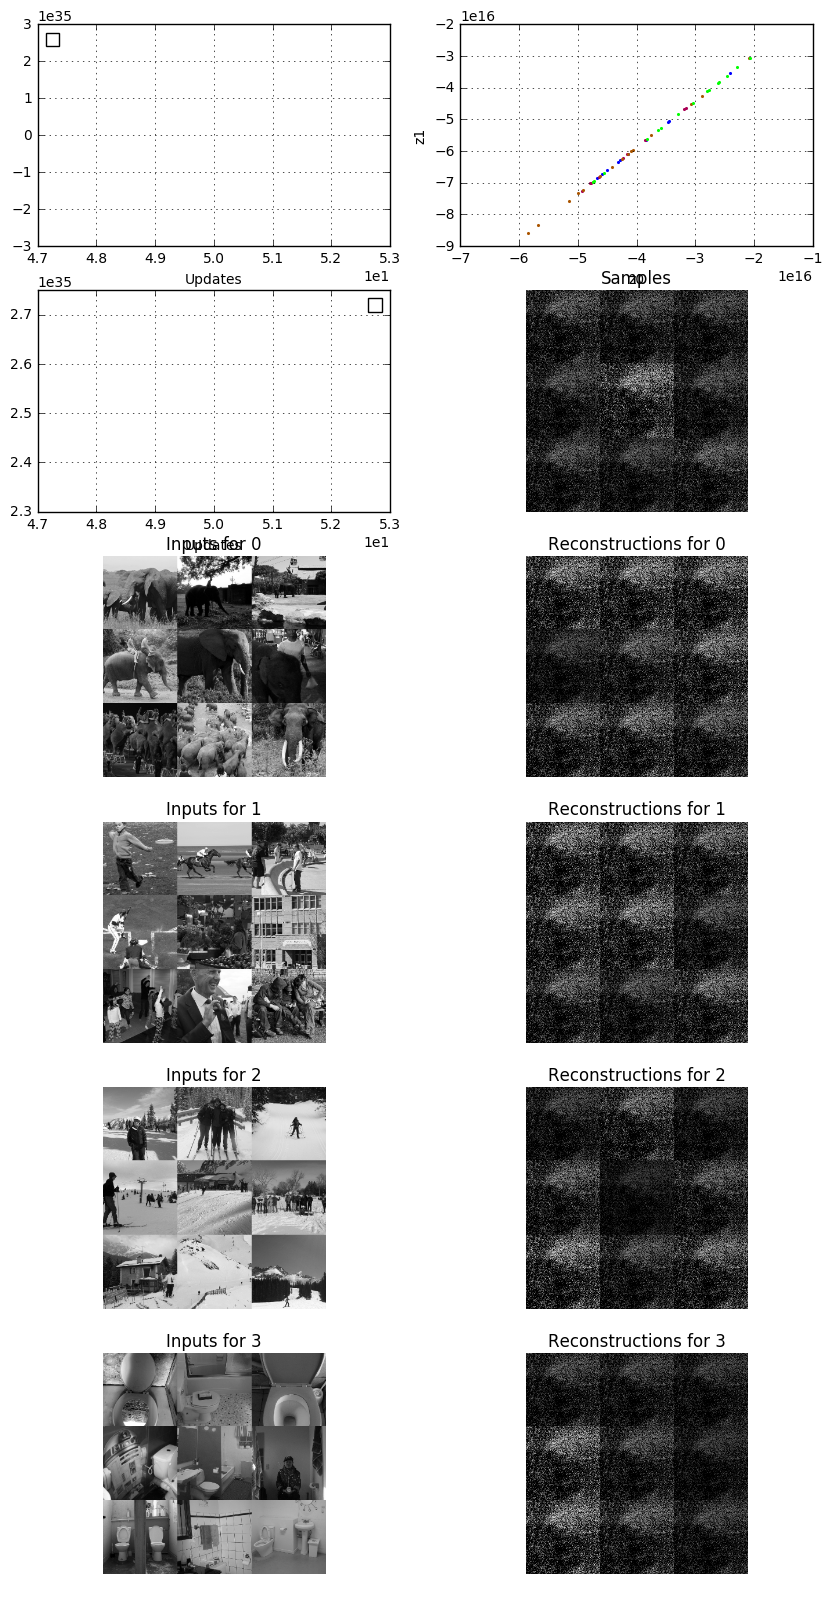

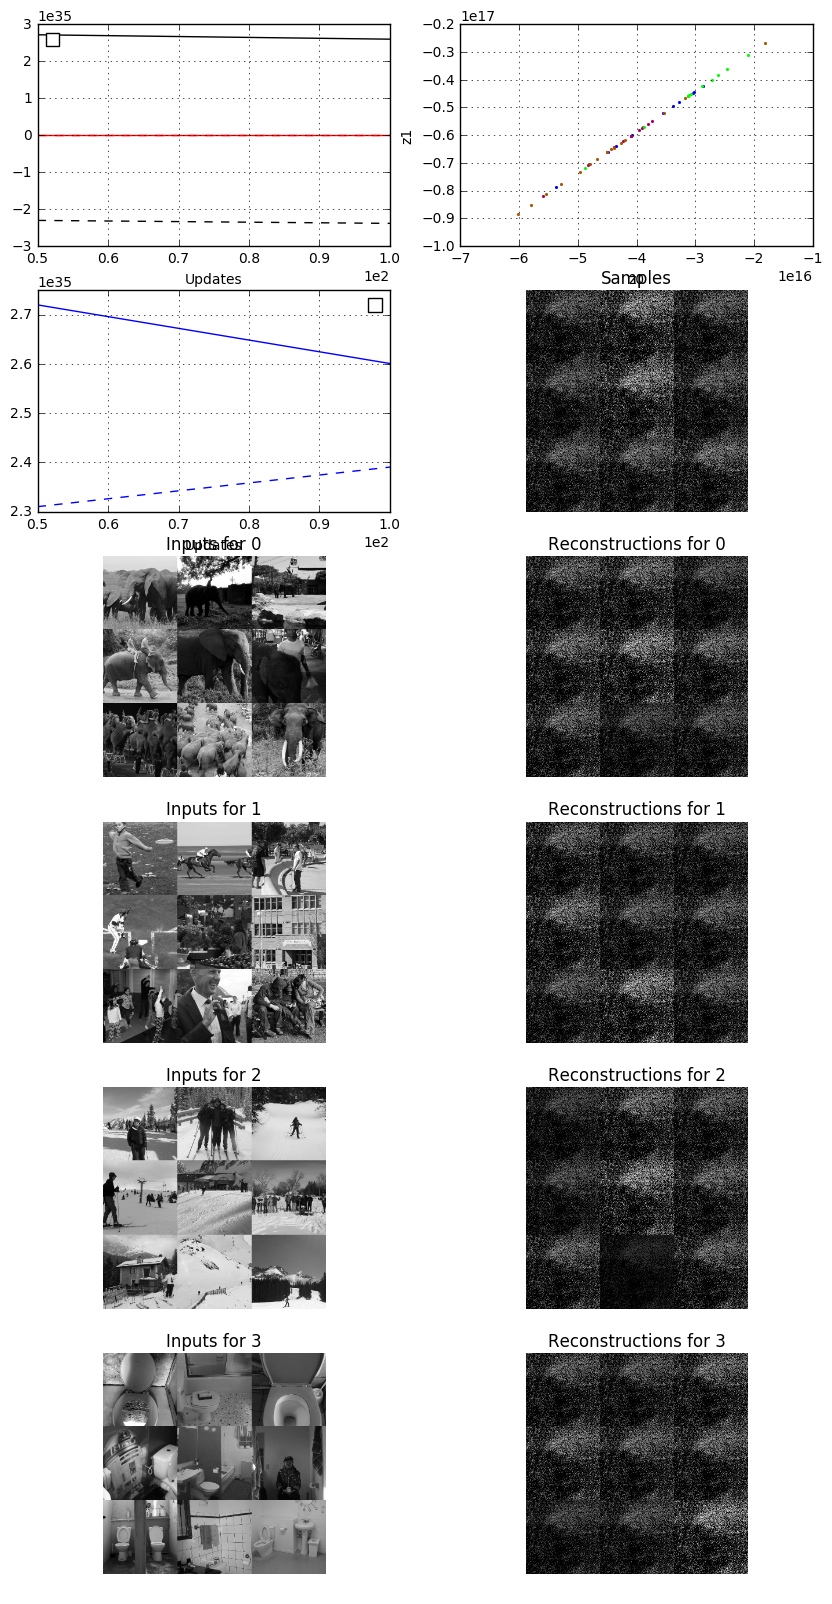

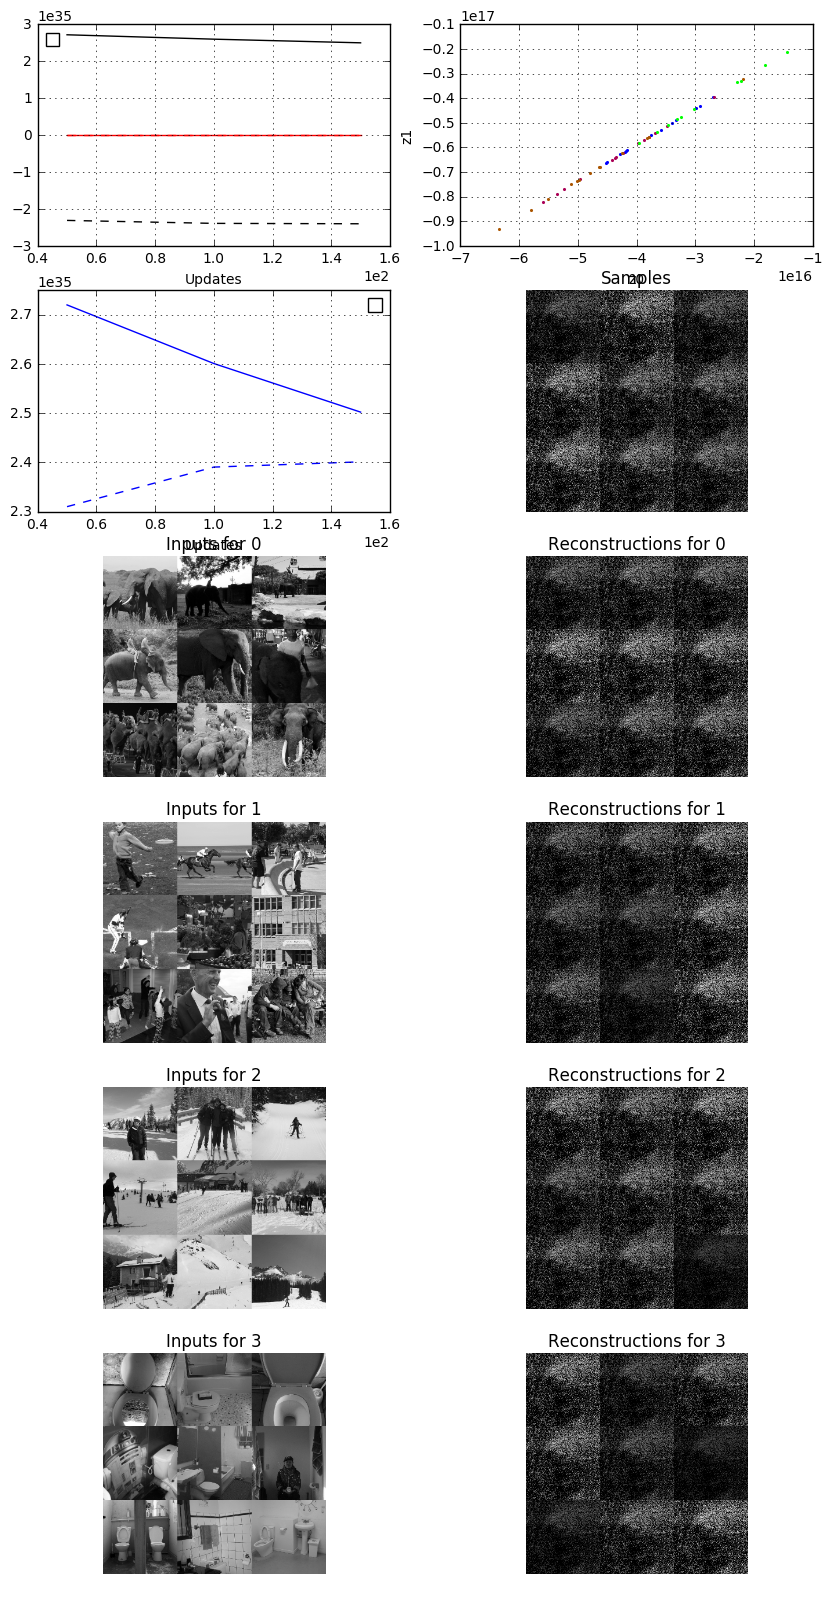

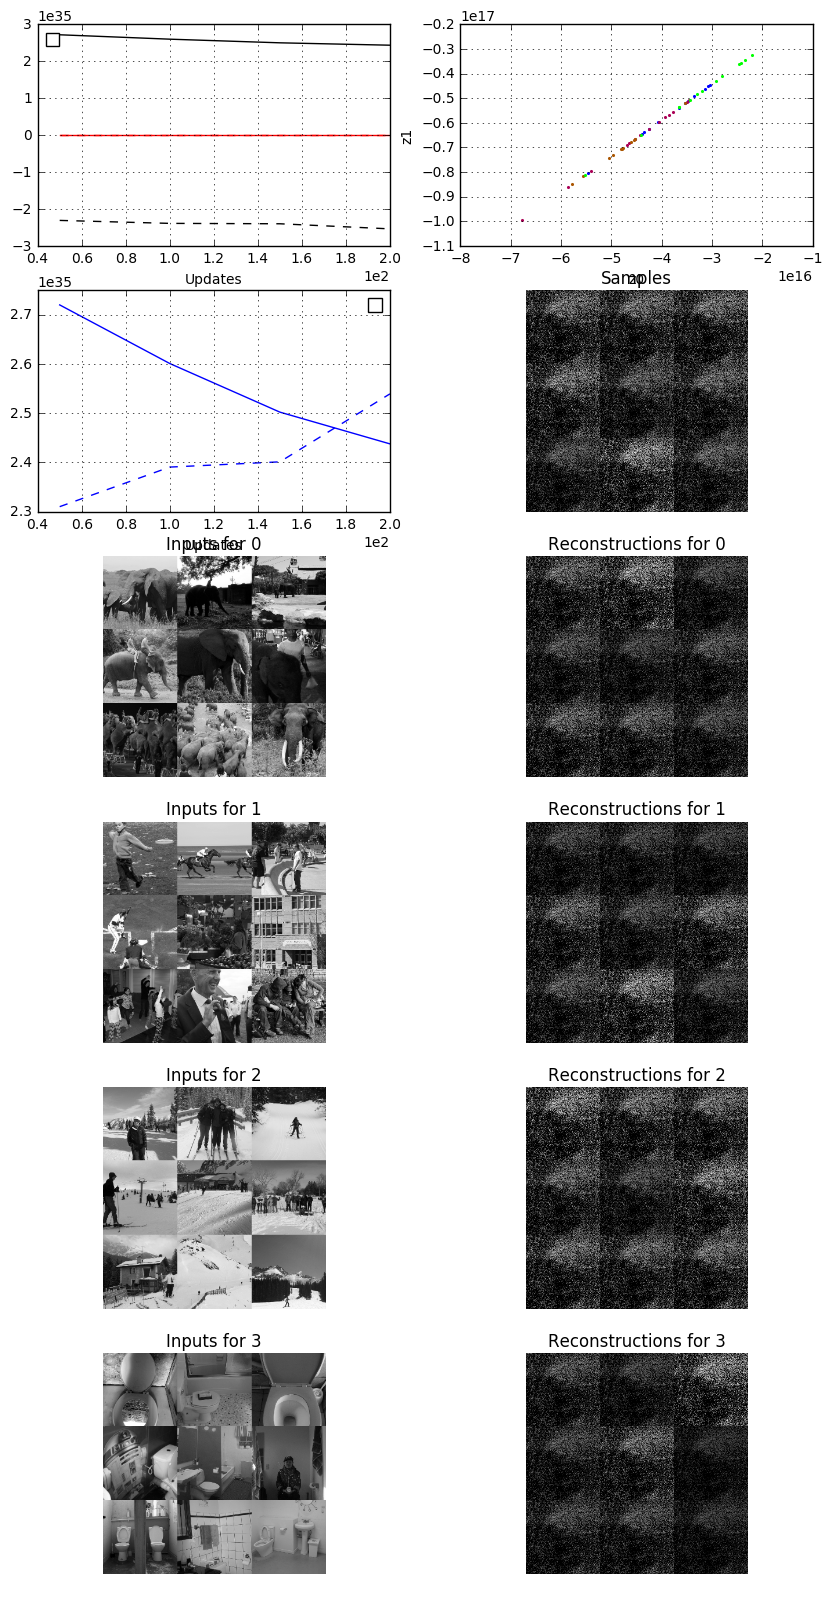

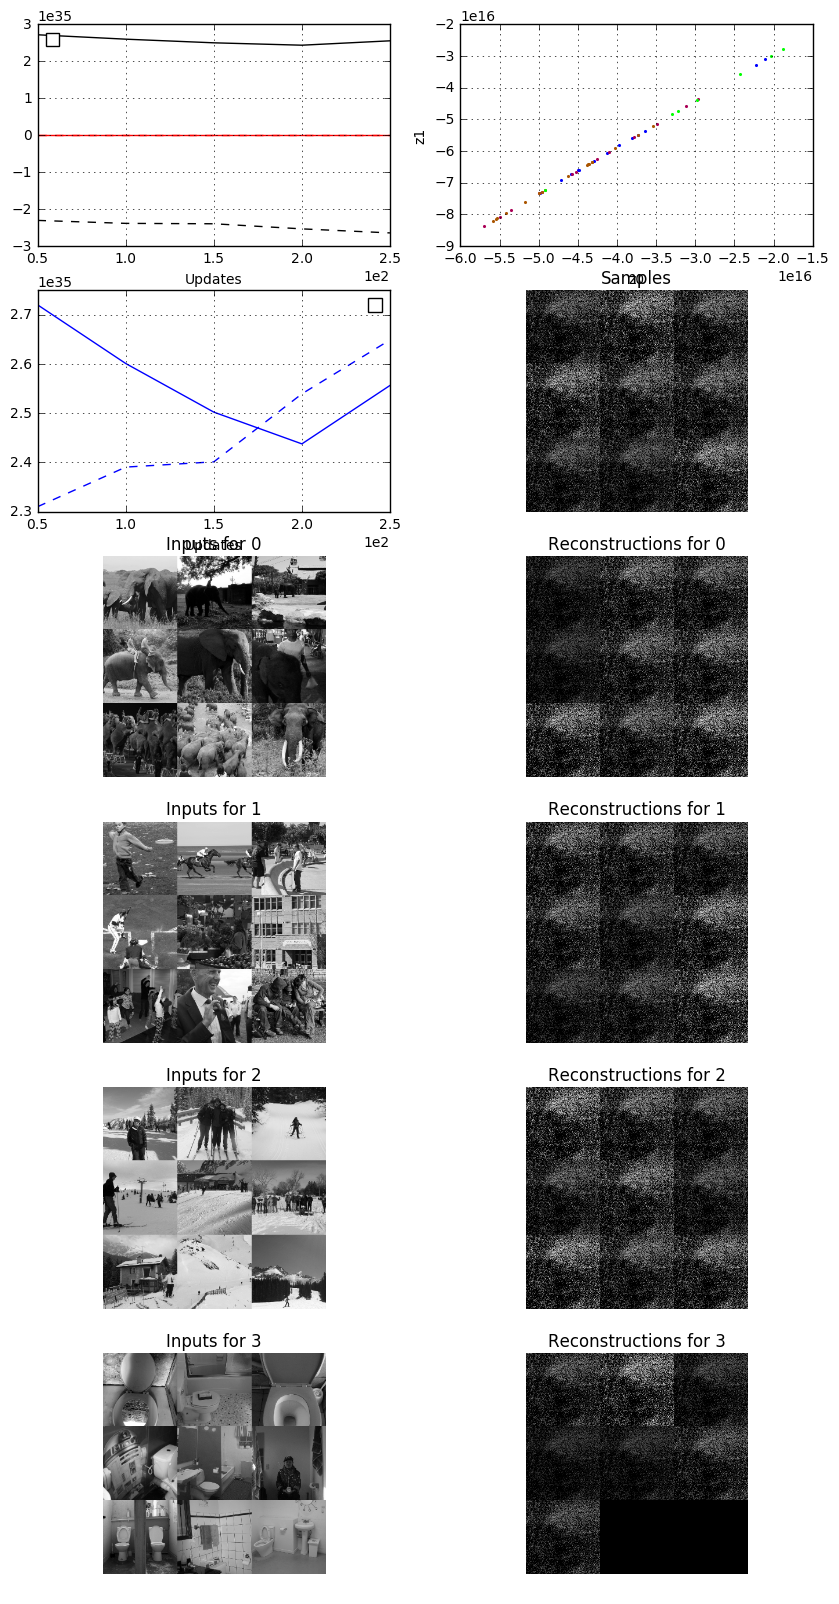

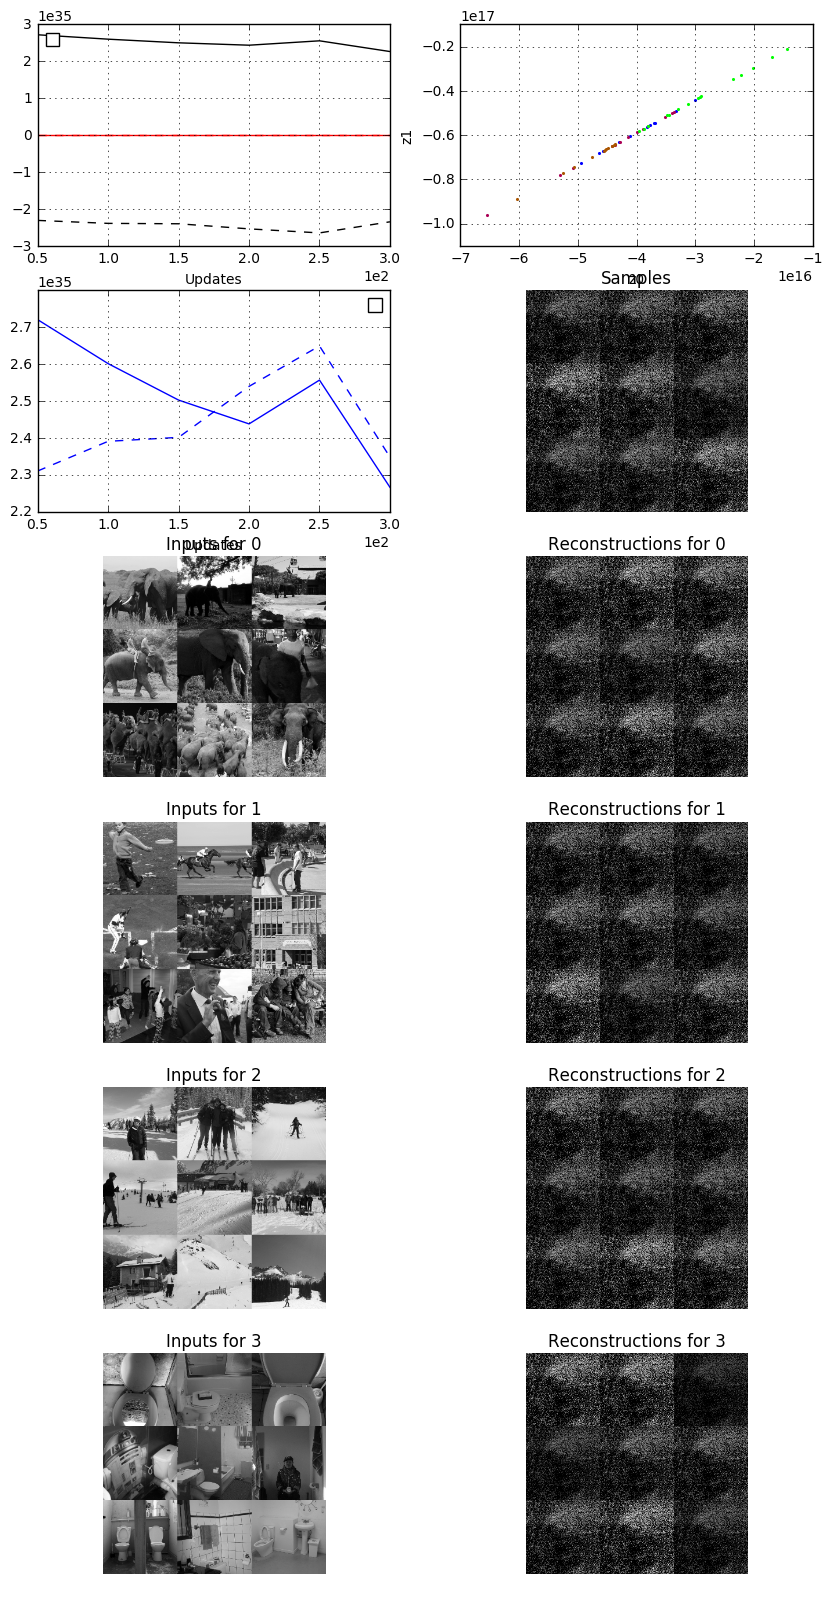

In [ ]:
import gc
batch_size = 50
samples_to_process = 1e6
val_interval = 50
reshape = 128
num_classes = 4
numberOfImages=3

LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
# plt.figure(figsize=(12, 24))
plt.figure()
valid_samples_processed = []

x_recons = []
y_valid_batches = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        y_batch = targets_train[idxs]
        out = f_train(x_batch, y_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            #out = f_eval(x_train, y_batch) # this is causing OOM errors, we need to use x_batch instead and average
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            idxs_eval = np.random.choice(range(x_valid.shape[0]), size=(batch_size), replace=False) 
            x_valid_batch = x_valid[idxs_eval]
            y_valid_batch = targets_valid[idxs_eval]
            y_valid_batches.append(y_valid_batch)
            class_batch = class_targets_valid[idxs_eval]
            
            out = f_eval(x_valid_batch, y_valid_batch)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid_batch)[0]
            x_sample = f_sample(np.random.normal(size=(batch_size, NUM_LATENT_Z)).astype('float32'))[0]
            x_recon = f_recon(x_valid_batch)[0]
            x_recons.append(x_recon)
            
#             plt.subplot(NUM_CLASSES+2,2,1)
            plt.figure(figsize=(10,20))
            plt.subplot(num_classes+2,2,1)
            plt.legend(['LL', 'log(p(x))'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,2)
            plt.cla()
            plt.xlabel('z0'), plt.ylabel('z1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                if i in class_batch:
                    plt.scatter(z_eval[class_batch==i, 0], z_eval[class_batch==i, 1], c=clr, s=5., lw=0, marker='o', )
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,3)
            plt.legend(['KL(q||p)'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, KL_train, color="blue")
            plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,4)
            plt.cla()
            plt.title('Samples')
            plt.axis('off')
            idx = 0
            canvas = np.zeros((reshape*numberOfImages, numberOfImages*reshape))
            for i in range(numberOfImages):
                for j in range(numberOfImages):
                    canvas[i*reshape:(i+1)*reshape, j*reshape:(j+1)*reshape] = x_sample[idx].reshape((reshape, reshape))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            c=0
            for k in range(5, 5 + num_classes*2, 2):
                plt.subplot(num_classes+2,2,k)
                plt.cla()
                plt.title('Inputs for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((128*numberOfImages, numberOfImages*128))
                for i in range(numberOfImages):
                    for j in range(numberOfImages):
                        canvas[i*reshape:(i+1)*reshape, j*reshape:(j+1)*reshape] = targets_valid[class_targets_valid==c][idx].reshape((reshape, reshape))
                        idx += 1
                plt.imshow(canvas, cmap='gray')

                plt.subplot(num_classes+2,2,k+1)
                plt.cla()
                plt.title('Reconstructions for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((reshape*numberOfImages, numberOfImages*reshape))
                for i in range(numberOfImages):
                    for j in range(numberOfImages):
                        if c in class_batch:
                            try:
                                canvas[i*reshape:(i+1)*reshape, j*reshape:(j+1)*reshape] = x_recon[class_batch==c][idx].reshape((reshape, reshape))
                                idx += 1
                            except:
                                continue
                plt.imshow(canvas, cmap='gray')
                c += 1
            plt.savefig("out52.png")
            display(Image(filename="out52.png"))
            clear_output(wait=True)
            gc.collect()

except KeyboardInterrupt:
    pass

In [11]:
x_recon.shape

(50, 16384)

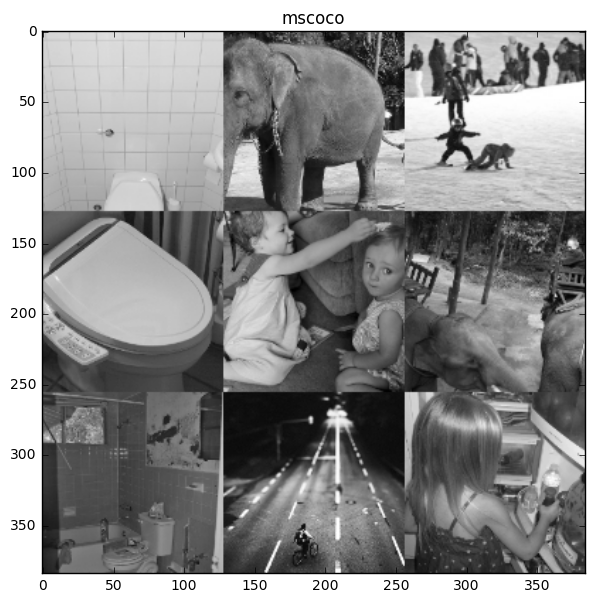

In [12]:
with open(TARGET_FILE, 'r') as f:
    class_targets_train = pickle.load(f)

with open(TARGET_VALIDATION_FILE, 'r') as f:
    class_targets_valid = pickle.load(f)
    
numberOfImages = 3
reshape = 128

def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((reshape*numberOfImages, numberOfImages*reshape))
    for i in range(numberOfImages):
        for j in range(numberOfImages):
            canvas[i*reshape:(i+1)*reshape, j*reshape:(j+1)*reshape] = x[idx].reshape((reshape, reshape))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()
    
plot_samples(targets_train[80:100],title='mscoco')  
    

(20, 50, 16384)
(20, 50, 16384)


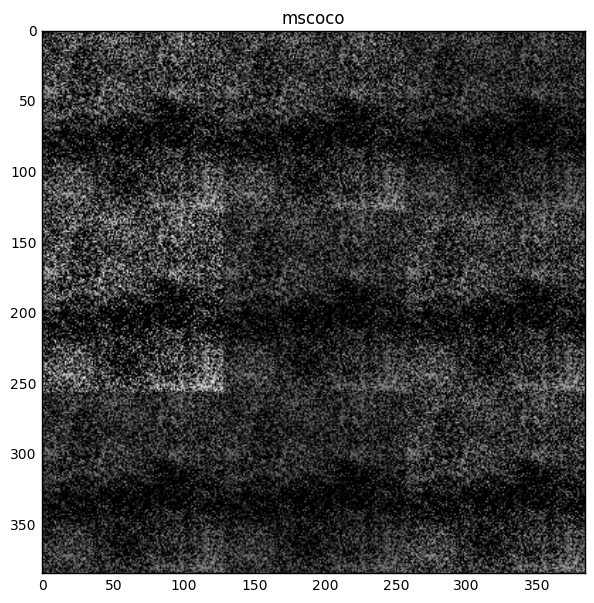

In [15]:
x_recons_np = np.asarray(x_recons)
print x_recons_np.shape

y_valid_batches_np = np.asarray(y_valid_batches)
print y_valid_batches_np.shape

plot_samples(x_recons[-1][10:50],title='mscoco') 

In [37]:
x_recons_cc = np.concatenate(x_recons_np, 0)
y_valid_batches_cc = np.concatenate(y_valid_batches_np, 0)
print x_recons_cc.shape
print y_valid_batches_cc.shape

res = np.argmax(x_recons_cc, axis=1)
print res

(1900, 4)
(1900, 4)
[1 1 1 ..., 2 0 1]


In [38]:
val = np.argmax(y_valid_batches_cc, axis=1)
print val

[0 1 1 ..., 1 1 2]


In [39]:
print np.where(res==val)

(array([   1,    2,    3,   10,   14,   15,   26,   27,   31,   32,   34,
         38,   39,   40,   43,   46,   48,   59,   63,   64,   72,   74,
         80,   81,   82,   85,   89,   93,   94,   98,  109,  116,  117,
        118,  125,  126,  127,  132,  134,  141,  142,  143,  145,  146,
        148,  151,  154,  156,  159,  163,  167,  173,  178,  182,  183,
        192,  196,  199,  202,  205,  207,  225,  229,  230,  232,  242,
        248,  250,  253,  255,  261,  262,  270,  271,  273,  274,  276,
        281,  282,  290,  292,  298,  301,  312,  314,  317,  318,  330,
        335,  343,  344,  351,  357,  358,  385,  386,  390,  391,  393,
        394,  395,  408,  411,  420,  421,  424,  425,  426,  431,  436,
        441,  450,  451,  452,  461,  463,  466,  471,  474,  479,  488,
        490,  492,  502,  506,  513,  514,  516,  521,  531,  535,  545,
        547,  550,  554,  565,  578,  584,  590,  594,  595,  597,  600,
        602,  603,  604,  606,  608,  610,  615,  

In [40]:
print len(np.where(res==val)[0]) / (float) (len(y_valid_batches_cc))

0.245263157895
